In [1]:
import logging
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns
from kalmanfilter import OptimizedKalmanFilter

logging.basicConfig(level=logging.INFO)
sns.set_theme(style='darkgrid')

In [2]:
df_ufi = pd.read_csv('us_financial_indices_2021.csv').assign(
    DATE=lambda d: pd.to_datetime(d.DATE)
).set_index('DATE')
df_ufi

,DJIA,SP500,NASDAQ100
DATE,,,
2021-01-04,30223.89,3700.65,12694.66
2021-01-05,30391.60,3726.86,12802.38
2021-01-06,30829.40,3748.14,12623.35
2021-01-07,31041.13,3803.79,12939.57
2021-01-08,31097.97,3824.68,13105.20
...,...,...,...
2021-12-27,36302.38,4791.19,16567.50
2021-12-28,36398.21,4786.35,16488.66
2021-12-29,36488.63,4793.06,16491.01


In [3]:
okf = OptimizedKalmanFilter(y=df_ufi.SP500, method='Powell', q_bound=(0, np.inf), r_bound=(0, np.inf), keep_history=False)
df_fit = okf.filter()
df_fit

INFO:kalmanfilter:self.x0: 4273.406626984127, self.v0: 82631.18656825871, self.q0: 82631.18656825871, self.r0: 82631.18656825871
INFO:kalmanfilter:
   direc: array([[-63243.51476561, -63243.51476561],
       [  1771.95252651,    -72.84904484]])
     fun: 1247.3194329899106
 message: 'Optimization terminated successfully.'
    nfev: 184
     nit: 4
  status: 0
 success: True
       x: array([11548.07253926,  1302.69136179])
INFO:kalmanfilter:process and measurement variances: 11548.072539262244, 1302.6913617921848


,y,x,v
DATE,,,
2021-01-04,3700.65,3708.464305,1284.918319
2021-01-05,3726.86,3725.164722,1182.640220
2021-01-06,3748.14,3746.007253,1181.765265
2021-01-07,3803.79,3798.425815,1181.757725
2021-01-08,3824.68,3822.242726,1181.757660
...,...,...,...
2021-12-27,4791.19,4784.823264,1181.757660
2021-12-28,4786.35,4786.208267,1181.757660
2021-12-29,4793.06,4792.423928,1181.757660


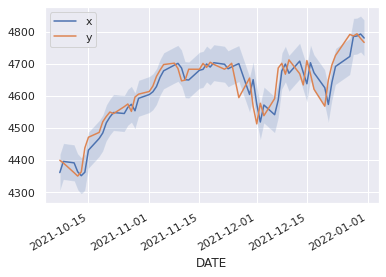

In [4]:
df_plt = df_fit.assign(x=lambda d: d.x.shift(), v= lambda d: d.v.shift()).tail(60)
df_plt[['x', 'y']].plot.line()
ci = norm.interval(alpha=0.9, loc=df_plt.x, scale=np.sqrt(df_plt.v)) 
plt.fill_between(df_plt.index, *ci, alpha=0.2)

In [5]:
lr_sp500 = np.log(df_ufi.SP500).diff().iloc[1:].ewm(span=6).mean()
okf = OptimizedKalmanFilter(y=lr_sp500, method='Powell', q_bound=(0, 1), r_bound=(0, 1), keep_history=False)
df_fit = okf.filter()
df_fit

INFO:kalmanfilter:self.x0: 0.0010633137012274279, self.v0: 8.961807843938706e-06, self.q0: 8.961807843938706e-06, self.r0: 8.961807843938706e-06
INFO:kalmanfilter:
   direc: array([[1., 0.],
       [0., 1.]])
     fun: -1013.2424996490719
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 1
  status: 0
 success: True
       x: array([6.61069614e-05, 6.61069614e-05])
INFO:kalmanfilter:process and measurement variances: 6.610696135189606e-05, 6.610696135189606e-05


,y,x,v
DATE,,,
2021-01-05,0.007058,0.004251,0.000035
2021-01-06,0.006262,0.005468,0.000040
2021-01-07,0.010072,0.008305,0.000041
2021-01-08,0.008297,0.008300,0.000041
2021-01-11,0.003077,0.005072,0.000041
...,...,...,...
2021-12-27,0.007078,0.005701,0.000041
2021-12-28,0.004767,0.005124,0.000041
2021-12-29,0.003805,0.004309,0.000041


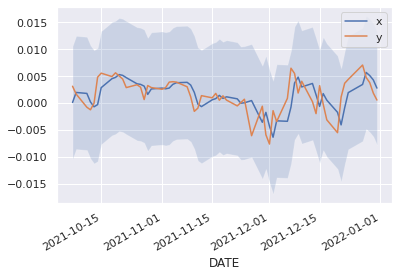

In [6]:
df_plt = df_fit.assign(x=lambda d: d.x.shift(), v= lambda d: d.v.shift()).tail(60)
df_plt[['x', 'y']].plot.line()
ci = norm.interval(alpha=0.9, loc=df_plt.x, scale=np.sqrt(df_plt.v)) 
plt.fill_between(df_plt.index, *ci, alpha=0.2)